# Vision Transformer (ViT) from Scratch

Here, one of the most significant contribution in the field of Computer Vision: the Vision Transformer (ViT).

With Self-Attention, each part of the image can "talk" to every other part, instantly understanding its relationship to the whole. ViTs treat an image as a collection of "words" — not individual pixels, but meaningful chunks, like the different elements in a painting. These chunks are called patches. The magic of Self-Attention lets the model understand the relationships between these patches.

CNNs, like detectives, focus on local details, meticulously examining each pixel and its immediate surroundings. They excel at recognizing simple patterns and shapes. ViTs, on the other hand, act like art critics, taking in the whole picture, understanding the relationships between elements, and interpreting the artist's intent. They excel at capturing complex relationships and dependencies across the image.

- **Accuracy:** In many cases, ViTs achieve higher accuracy than CNNs, especially on tasks that require understanding complex relationships or recognizing nuanced features.
- **Scalability:** ViTs exhibit faster neural scaling laws. This means they become more accurate as the model size increases, while CNNs tend to plateau in performance.

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# The Transformer Encoder

In [4]:
class MultiHeadSelfAttention(nn.Module):
    """
    The Attention Layer.
    """

    def __init__(self, n_embed, n_head, dropout=0.1) -> None:
        super(MultiHeadSelfAttention, self).__init__()
        assert n_embed % n_head == 0, "n_embed must be divisible by n_head"
        self.n_embed= n_embed
        self.n_head = n_head
        self.d_head = n_embed // n_head
        # query, key, value projections in a single batch
        self.c_attn= nn.Linear(n_embed, 3 * n_embed)
        # output projection
        self.o_proj= nn.Linear(n_embed, n_embed)
        # regularization
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, x):
        B, T, C= x.size() # batch_size, seq_length, embedding dim (d_model)
        assert C == self.n_embed, "Input embedding dimension must match model embedding dimension"
        # 1. calculate query, key, values for all heads
        qkv= self.c_attn(x)
        q, k, v= qkv.split(self.n_embed, dim=2) # q,k,v -> (B, T, C)
        # 2. reshape for Multi-Head Attention
        q= q.view(B, -1, self.n_head, self.d_head).transpose(1, 2) # q,k,v view   -> (B, T, nh, dh)
        k= k.view(B, -1, self.n_head, self.d_head).transpose(1, 2) # q,k,v transp -> (B, nh, T, dh)
        v= v.view(B, -1, self.n_head, self.d_head).transpose(1, 2)
        # 3. Attention - the 'scaled dot product'
        attn= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.d_head))
        # normalize Attention scores
        attn= F.softmax(attn, dim=-1)
        attn= self.dropout(attn)
        # 4. compute Attention output
        y= attn @ v # (B, nh, T, dh)
        # 5. concatenate multi-head outputs -- re-assembly all head outputs side by side
        y= y.transpose(1, 2).contiguous().view(B, T, C)
        # 6. output projection
        return self.o_proj(y)


In [5]:
class FeedForward(nn.Module):
    """
    The Feed Forward Network (FFN).
    """

    def __init__(self, n_embed, d_ff, dropout=0.1) -> None:
        super(FeedForward, self).__init__()
        self.ffn= nn.Sequential(
            nn.Linear(n_embed, d_ff),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(d_ff, n_embed),
        )


    def forward(self, x):
        x= self.ffn(x)

        return x


In [6]:
class EncoderBlock(nn.Module):
    """
    The Ecoder Block (pre-normalization version).
    """

    def __init__(self, n_embed, n_head, d_ff, dropout=0.1) -> None:
        super(EncoderBlock, self).__init__()
        self.ln_1= nn.LayerNorm(n_embed)
        self.attn= MultiHeadSelfAttention(n_embed, n_head, dropout)
        self.dropout1= nn.Dropout(p=dropout)
        self.ln_2= nn.LayerNorm(n_embed)
        self.ffn = FeedForward(n_embed, d_ff, dropout)
        self.dropout2= nn.Dropout(p=dropout)


    def forward(self, x):
        x_norm= self.ln_1(x)
        x= x + self.dropout1(self.attn(x_norm))
        x_norm= self.ln_2(x)
        x= x + self.dropout2(self.ffn(x_norm))

        return x


With the Attention Layer and Feed Forward Network in place, we can assemble a Transformer Encoder. The Transformer Encoder is essentially a stack of N Encoder Blocks. Remember, Transformers are like Legos — the input dimension is the same as the output dimension, so you can stack as many blocks as you want (or as your memory allows).

In [7]:
class TransformerEncoder(nn.Module):
    """
    The Transformer Encoder is essentially a stack of N Encoder Blocks.
    """

    def __init__(self, n_embed=512, n_layer=6, n_head=8, d_ff=2048, dropout=0.1) -> None:
        super(TransformerEncoder, self).__init__()
        self.transformer= nn.ModuleList([
            EncoderBlock(n_embed, n_head, d_ff, dropout) for _ in range(n_layer)
        ])
        self.ln_final= nn.LayerNorm(n_embed)


    def forward(self, x):
        for block in self.transformer:
            x= block(x)

        return self.ln_final(x)


In [ ]:
model= TransformerEncoder().to(device)
data= torch.randn(16, 128, 512).to(device)
model.eval()
model(data).shape

torch.Size([16, 128, 512])

# Building the final ViT

ViTs start by dividing the image into a grid of smaller, rectangular pieces, like individual puzzle pieces. These pieces are the patches. The size of the patch, determined by a parameter called "patch size," decides how much detail each piece captures. A larger patch size means more detail, but fewer pieces overall, like a puzzle with fewer, larger pieces.

Once the image is divided into patches, the real magic begins — the patches are embedded into vectors. This process converts each patch, a visual chunk of information, into a mathematical representation, a sequence of numbers. We can think of this as translating the image into a language the model can understand.

To preserve the spatial information within the image, the positional encoding comes in. Imagine each patch has a unique address on the image grid. Positional encoding adds a numerical "address" to each patch, allowing the model to understand where it is relative to other patches. Now, we have a sequence of "words" with their spatial addresses. This sequence is fed into the heart of the ViT model — the Transformer encoder.

A special "classification token" is added to the beginning of the patch sequence. Think of it as a placeholder for the final answer. This token gathers information from the entire patch sequence, becoming a representation of the whole image, and summarizing the important features and relationships. The classification token is then fed through a final layer, where the model ultimately makes its prediction, be it a category label, an object detection, or any other task.

In summary, we mainly need 3 components to build the Input Embedding:

- Convert the image into patches, and then vectors.
- Add positional encoding.
- Add the CLS token.

In [8]:
class Embedding(nn.Module):
    """
    Initializes the Embedding module.
    """

    def __init__(self, image_height, image_width, patch_height, patch_width, n_embed,
                 dropout=0.1) -> None:
        super(Embedding, self).__init__()
        # calculate the number of patches and the dimension of each patch
        num_patches= (image_height // patch_height) * (image_width // patch_width)
        patch_dim= channels * patch_height * patch_width

        # unfold images of shape (batch_size, channels, image_height, image_width)
        # into patches of shape  (batch_size, num_patches, patch_dim)
        self.patch_embed= nn.Sequential(
            Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=patch_height, pw=patch_width),
            nn.LayerNorm(patch_dim),       # normalize each patch
            nn.Linear(patch_dim, n_embed), # project patches to embedding dimension
        ) # embedding shape (batch_size, num_patches, n_embed)

        # define CLS token and positional embeddings -- both as learnable parameters
        self.cls_token= nn.Parameter(torch.zeros(1, 1, n_embed))
        self.pos_embed= nn.Parameter(torch.zeros(1, num_patches +1, n_embed))
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, img):
        x= self.patch_embed(img)
        B, P, C= x.size()  # (batch_size, num_patches, n_embed)
        # repeat class token (CLS) for each image in the batch
        cls_token= repeat(self.cls_token, '1 1 d -> b 1 d', b=B)
        # concatenate class token (CLS) with patch embeddings
        x= torch.cat((cls_token, x), dim=1)
        # add positional embedding to the input
        x= x + self.pos_embed[:, :(P + 1)]  # (batch_size, num_patches + 1, n_embed)

        return self.dropout(x)


We need to check that we are correctly splitting the image into a number of patches that is an integer. In other words, we need to check that **image_height** and **image_width** are divisible by **patch_dimension**. Next step is to convert the patch into embeddings. Remember that here an image has $C = 3$ dimensions. We need to unfold this dimension, and compress each patch of dimension $patch\_size \times patch\_size \times C$. Then we need to define the **CLS** token and the positional embedding. They are both learned parameters (randomly initialized).

In [9]:
class MLPHead(nn.Module):
    """
    The MLP (classification) head.
    """

    def __init__(self, n_embed, d_ff, num_classes, dropout=0.1, fine_tune=False) -> None:
        super(MLPHead, self).__init__()
        if fine_tune:
            self.c_head= nn.Linear(n_embed, num_classes, bias=False)
        else:
            self.c_head= nn.Sequential(
                nn.Linear(n_embed, d_ff, bias=False),
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(d_ff, num_classes, bias=False),
            )


    def forward(self, x):
        x= self.c_head(x)

        return x


Finally, we have to define the Transformer encoder that we have defined before, and add a classification head. The MLP head, also known as the classification head, is the final part of the Vision Transformer (ViT) pipeline. It is responsible for processing the output of the Transformer encoder (particularly the class token) to produce the final predictions for a classification task.

- During fine-tuning, the MLP head may be replaced with a single linear layer (no hidden layers). This reduces complexity since the model already has rich feature representations from pretraining.

In [10]:
class ViT(nn.Module):
    """
    Initializes a Vision Transformer (ViT) model.
    """

    def __init__(self, image_size, patch_size, channels, num_classes, pool='cls',
                 n_embed=512, n_layer=6, n_head=8, d_ff=2048, dropout=0.1, fine_tune=False) -> None:
        super(ViT, self).__init__()
        image_height, image_width= self.pair(image_size)
        patch_height, patch_width= self.pair(patch_size)
        # ensure that the image dimensions are divisible by the patch sizes
        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
            'Image dimensions must be divisible by the patch size.'
        # ensure the pooling strategy is valid
        assert pool in {'cls', 'mean'}, 'Pool type must be either cls (cls token) or mean (mean pooling).'
        # pooling strategy (CLS token or mean of patches)
        self.pool= pool

        # define the patch, CLS token, and positional embeddings
        self.embedding= Embedding(
            image_height, image_width, patch_height, patch_width, n_embed, dropout
        )
        # define the transformer encoder
        self.encoder= TransformerEncoder(n_embed, n_layer, n_head, d_ff, dropout)
        # identity layer (no change to the tensor)
        self.latent_space= nn.Identity()
        # classification head
        self.lm_head= MLPHead(n_embed, d_ff, num_classes, dropout, fine_tune)

        # initialize parameters with Glorot / fan_avg
        for p in self.parameters():
            if p.dim()> 1:
                nn.init.xavier_uniform_(p)


    def pair(self, x):
        """
        Utility function: Converts a single value into a tuple of two values.
        If x is already a tuple, it is returned as is.
        """
        return x if isinstance(x, tuple) else (x, x)


    def forward(self, img):
        # img(batch_size, channels, image_height, image_width)
        x= self.embedding(img)  # x(batch_size, num_patches + 1, n_embed)
        # forward the the transformer encoder
        x= self.encoder(x)

        # extract class token and feature map
        cls_token= x[:, 0]
        feature_map= x[:, 1:]
        # apply pooling operation: 'cls' token or mean of patches
        pool_output= cls_token if self.pool == 'cls' else feature_map.mean(dim=1)

        # apply the identity transformation (no change to the tensor)
        pool_output= self.latent_space(pool_output)
        # forward the classifier
        logits= self.lm_head(pool_output)

        # return CLS token, patch embeddings, and classification results
        return cls_token, feature_map, logits


**Forward pass:** We have initialized all the components of our ViT, now we just have to call them in the right order for the forward pass.

- We first convert the input image into patches, and unfold each patch into a vector.
- Then we repeat CLS tokens (along the batch dimension), and we concatenate it on the dimension 1, which is the sequence length. Indeed we learn the parameters for one vector, but it needs to be concatenated to each image, this is why we expand one dimension.
- Then we add the position embedding to each token.

Next we apply the Transformer Encoder. We then mainly use it to build an output containing 3 things:

- The CLS Token (a single vector representation of the image).
- The Feature Map (A vectorized representation of each patch of the image)
- Classification Head Logits (Optional): This is used in the case of classification task. Note that Vision Transformer can be trained with different tasks, but classification is the task that was originally used.

The math reveals a fascinating aspect of ViTs: they rely on data-driven learning, unlike CNNs which rely on fixed, pre-defined filters. ViTs learn to "see" patterns in images based on the data they're trained on, demonstrating a unique ability to adapt to different visual styles and complexities. This explains why they perform exceptionally well on large datasets, as they can capture more subtle and nuanced relationships.

In [11]:
# --- ViT Large hyperparameters config ---
image_size= 224
patch_size= 16
channels= 3
num_classes= 1000  # ImageNet has 1000 classes
pool='cls'
n_embed= 1024
n_layer= 24
n_head= 16
d_ff= 4 * n_embed

model= ViT(image_size, patch_size, channels, num_classes, pool,
           n_embed, n_layer, n_head, d_ff).to(device)

count_parameters(model)

model

Number of parameters: 311593472


ViT(
  (embedding): Embedding(
    (patch_embed): Sequential(
      (0): Rearrange('b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=16, pw=16)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=1024, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (transformer): ModuleList(
      (0-23): 24 x EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadSelfAttention(
          (c_attn): Linear(in_features=1024, out_features=3072, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ffn): FeedForward(
          (ffn): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
       

In [12]:
import torch.cuda as cuda

img= [np.random.randn(3, 224, 224) for _ in range(64)]
img= torch.tensor(np.array(img), dtype=torch.float32).to(device)

cuda.reset_peak_memory_stats()
# Run the model
model.eval()
cls_token, feature_map, logits= model(img)
# Measure peak memory usage
peak_memory= cuda.max_memory_allocated()

print(f'CLS Token Shape: {cls_token.shape}')
print(f'Feature Map Shape: {feature_map.shape}')
print(f'Classification Head Logits Shape: {logits.shape}')
print(f"Forward Pass Memory: {np.round(peak_memory / 10**6, decimals=2)} MB")

del img, cls_token, feature_map, logits

CLS Token Shape: torch.Size([64, 1024])
Feature Map Shape: torch.Size([64, 196, 1024])
Classification Head Logits Shape: torch.Size([64, 1000])
Forward Pass Memory: 25234.47 MB


In [ ]:
# https://medium.com/@cristianleo120/the-math-behind-vision-transformers-95a64a6f0c1a
# https://towardsdatascience.com/how-to-train-a-vision-transformer-vit-from-scratch-f26641f26af2
# https://medium.com/@dancerworld60/building-vision-transformers-from-scratch-a-comprehensive-guide-dd244abaad15

# Training the ViT model from scratch

torchvision: Provides utilities for handling vision-related tasks, including datasets and transformations.

Before feeding images into the Vision Transformer, we need to preprocess them. The model expects images of size 224x224, so we'll resize our CIFAR-10 images and normalize them.

In [13]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [14]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 64
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:18<00:00, 9.21MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
len(train_loader), len(val_loader)

(704, 79)

# The Trainer Function and Cosine LR Decay

TODO:
- Training using data augmentation (Transformers are data hungry).
- Logging Learning Rate.
- Metric Tracking: adding accuracy, precision, or other metrics to monitor training and validation performance.
- Early Stopping: based on validation loss to prevent overfitting.
- More epochs of training.

In [16]:
class CosineLRDecay:
    """
    Modulates learning rate (LR) based on the iteration (step) number which LR there should be.
    """

    def __init__(self, optimizer, min_lr, max_lr=3e-4, warmup_steps=10,
                 max_steps=50) -> None:
        self.optimizer= optimizer
        self.min_lr= min_lr
        self.max_lr= max_lr
        self.warmup_steps= warmup_steps
        self.max_steps= max_steps
        self.last_step= 0
        self.last_lr= None


    def get_last_lr(self):
        return self.last_lr


    def get_lr(self, it):
        # 1) linear warmup for warmup_iters steps
        if it< self.warmup_steps:
            return self.max_lr * (it+1) / self.warmup_steps
        # 2) if it > lr_decay_iters, return min learning rate
        if it> self.max_steps:
            return self.min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio= (it - self.warmup_steps) / (self.max_steps - self.warmup_steps)
        assert 0 <= decay_ratio <= 1
        # coeff starts at 1 and goes to 0
        coeff= 0.5 * (1.0 + math.cos(math.pi * decay_ratio))

        return self.min_lr + coeff * (self.max_lr - self.min_lr)


    def step(self):
        self.last_lr= self.get_lr(self.last_step)
        for param_group in self.optimizer.param_groups:
            param_group['lr']= self.last_lr

        self.last_step += 1


In [17]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=10, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            model.train()
            _, _, logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # --- update the parameters using the gradient ---
            optimizer.step()
            scheduler.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    _, _, logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [18]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            _, _, logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


# Training setup using TF32 and Fused AdamW

In [19]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- ViT Base hyperparameters config ---
image_size= 224
patch_size= 16
channels= 3
num_classes= 10 # CIFAR-10 has 10 classes
pool='cls'
n_embed= 768
n_layer= 12
n_head= 12
d_ff= 4 * n_embed

vit_model= ViT(image_size, patch_size, channels, num_classes, pool, n_embed, n_layer,
               n_head, d_ff).to(device)

count_parameters(vit_model)


epochs= 10
# train_loader has size 704, so 10 epochs have 7,040 steps
steps= len(train_loader) * epochs
learning_rate= 1e-4

max_lr= learning_rate
min_lr= 5e-5
warmup_steps= 500
max_steps= steps

optimizer= torch.optim.AdamW(
    vit_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.01,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()
scheduler= CosineLRDecay(optimizer, min_lr, max_lr, warmup_steps, max_steps)


Number of parameters: 88190208
Using fused AdamW: True


In [20]:
tr_loss, vl_loss= trainer(vit_model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, eval_interval=1, verbose=True)

Epoch: 0 | Train Loss: 1.8026 | Val Loss: 1.6053 | dt/epoch: 117253.39ms
Epoch: 1 | Train Loss: 1.4621 | Val Loss: 1.4003 | dt/epoch: 116274.76ms
Epoch: 2 | Train Loss: 1.3061 | Val Loss: 1.3118 | dt/epoch: 115808.99ms
Epoch: 3 | Train Loss: 1.1990 | Val Loss: 1.1893 | dt/epoch: 115398.37ms
Epoch: 4 | Train Loss: 1.0933 | Val Loss: 1.1655 | dt/epoch: 115747.87ms
Epoch: 5 | Train Loss: 0.9980 | Val Loss: 1.1239 | dt/epoch: 116269.14ms
Epoch: 6 | Train Loss: 0.8977 | Val Loss: 1.1144 | dt/epoch: 116168.86ms
Epoch: 7 | Train Loss: 0.7977 | Val Loss: 1.1185 | dt/epoch: 115938.24ms
Epoch: 8 | Train Loss: 0.6989 | Val Loss: 1.1278 | dt/epoch: 116689.03ms
Epoch: 9 | Train Loss: 0.6048 | Val Loss: 1.2201 | dt/epoch: 116298.91ms


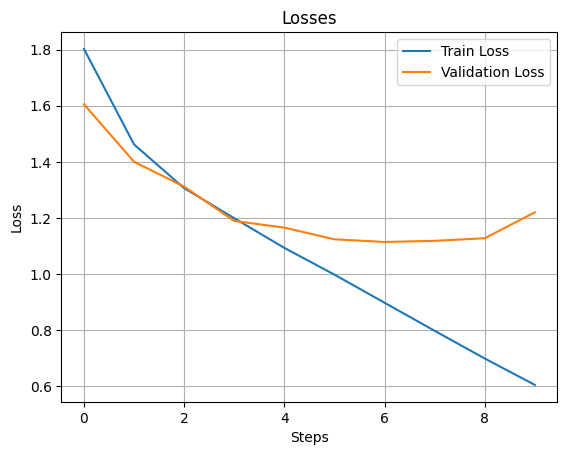

In [21]:
# Plot
plt.plot(tr_loss, label='Train Loss')
plt.plot(vl_loss, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [25]:
vit_acc= evaluate_model(vit_model, test_loader, device, verbose=True)

Accuracy: 63.09%


ViTs also have some limitations:

- **Data Requirements:** ViTs generally need larger datasets than CNNs to reach their full potential, as their data-driven approach requires more examples to learn complex patterns.
- **Computational Cost:** For smaller models, ViTs can be more computationally expensive than CNNs, especially for inference, as their global attention mechanism requires more computations.

So, when should we use ViTs and when should we stick with CNNs?

- **Large Datasets:** If you have a large amount of training data and need to achieve high accuracy, ViTs are a powerful option.
- **Complex Relationships:** For tasks requiring the understanding of intricate relationships across the entire image, ViTs are a better choice.
- **Scalability:** If you need a model that scales well, meaning its performance improves as its size increases, ViTs are the way to go.

In [ ]:
# https://github.com/kyegomez/Vit-RGTS/blob/main/train.py
# https://github.com/FrancoisPorcher/vit-pytorch/tree/5a105d7df3b22815c322d7d386494a49e6c08825